The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.1e-3

In [2]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [10]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [4]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [5]:
def load_exp_data(direc, cut=None, layer_size=25, n_exc=800, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if reverse:
        file_names = [f for f in reversed(file_names)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            summed_incoming_weights = loaded['w_r_e_summed']
            summed_incoming_weights_e_i = loaded['w_r_e_i_summed']

            try:
                exc_cells_initially_active = loaded['exc_cells_initially_active'].astype(float)
                exc_cells_newly_active = loaded['exc_cells_newly_active'].astype(float)
            except KeyError as e:
                exc_cells_initially_active = loaded['exc_raster'].astype(float)
                exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :]
                exc_cells_newly_active = None
            inh_raster = loaded['inh_raster']

            try:
                surviving_cell_indices = loaded['surviving_cell_indices'][0].astype(bool)
                if exc_cells_initially_active is not None and exc_cells_initially_active.shape[0] > 0:
                    exc_cells_initially_active[0, :] = exc_cells_initially_active[0, :] * dt
                if exc_cells_newly_active is not None and exc_cells_newly_active.shape[0] > 0:
                    exc_cells_newly_active[0, :] = exc_cells_newly_active[0, :] * dt
            except KeyError as e:
                surviving_cell_indices = np.ones(summed_incoming_weights.shape[0], dtype=bool)
        

            summed_incoming_weights = summed_incoming_weights[(surviving_cell_indices).nonzero()[0]]

            first_spk_times = process_single_activation(exc_cells_initially_active, n_exc)

            layers_active = []
            layer_weights = []

            for i in range(0, len(first_spk_times), layer_size):
                layer_active = np.any(~np.isnan(first_spk_times[i:i+layer_size]))
                layers_active.append(layer_active)

                layer_weight = np.sum(summed_incoming_weights[i:(i + layer_size)])
                layer_weights.append(layer_weight)

            data = {
                'index': i_f,
                'layers_active': layers_active,
                'first_spk_times': first_spk_times,
                
                'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
                'median_incoming_summed_weights': np.median(summed_incoming_weights),
                'std_incoming_summed_weights': np.std(summed_incoming_weights),
                'summed_incoming_weights': summed_incoming_weights,
                
                'mean_incoming_summed_weights_e_i': np.mean(summed_incoming_weights_e_i),
                'median_incoming_summed_weights_e_i': np.median(summed_incoming_weights_e_i),
                'std_incoming_summed_weights_e_i': np.std(summed_incoming_weights_e_i),
                'summed_incoming_weights_e_i': summed_incoming_weights_e_i,
                
                'exc_cells_initially_active': exc_cells_initially_active,
                'exc_cells_newly_active': exc_cells_newly_active,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                'surviving_cell_indices': surviving_cell_indices,
            }
            return data
        yield i_f, lazy_load

In [17]:
colors_for_trials = ['#cf496d', '#d4aa37', '#79d5a9', '#4f89af', '#20424d']

# [207, 73, 109], [243, 208, 109], [121, 213, 169] [79, 136, 175] [32, 66, 77]

In [60]:
def downsample_raster(raster, cell_idxs_to_show):
    j = 0
    sorted_raster = np.array([y for y in sorted(raster.T, key=lambda x: x[1])]).T
    downsampled = []
    for i in range(sorted_raster.shape[1]):
        while j < len(cell_idxs_to_show) and sorted_raster[1, i] > cell_idxs_to_show[j]:
            j += 1
        if j == len(cell_idxs_to_show):
            break
        if sorted_raster[1, i] == cell_idxs_to_show[j]:
            downsampled.append(sorted_raster[:, i])
    if len(downsampled) > 0:
        return np.stack(downsampled).T
    else:
        return np.array([])

def make_figure_1_sparse(name, cell_range=(0, 800), shown_range=(0, 800), per_shown_per_layer=1., layer_size=20, timepoints = [0, 72, 73], verify_chain_timepoints=None, color='black'):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
    
    colors = get_equally_spaced_colors(20, cmap='gist_ncar')
    
    def rendition_label(n):
        if n == 0:
            n = 1
            return f'{n}' + r'$^{st}$ rendition'
        else:
            return f'{n}' + r'$^{th}$ rendition'
        
    if verify_chain_timepoints is None:
        verify_chain_timepoints = np.arange(3)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        if d_idx >= 20:
            continue
        print(exp_dir_name)
        scale = 1.1
        
        fig = plt.figure(constrained_layout=True, figsize=(5 * len(timepoints) * scale, 5 * scale))
        gs = gridspec.GridSpec(ncols=len(timepoints), nrows=3, figure=fig)
        axs = [(fig.add_subplot(gs[:1, i]), fig.add_subplot(gs[1:, i])) for i in range(len(timepoints))]
           
        timepoint_names = [rendition_label(t * 10) for t in timepoints]
        j = 0
        
        first_first_spk_in_range = None
        last_first_spk_in_range = None
        
        to_show_mask = []
        for i in range(0, cell_range[1] - cell_range[0], layer_size):
            if i >= shown_range[0] and i < shown_range[1]:
                to_show_mask.append(np.random.rand(layer_size) < per_shown_per_layer)
            else:
                to_show_mask.append(np.zeros((layer_size,)).astype(bool))
        to_show_mask = np.concatenate(to_show_mask, axis=0)
        cell_idxs_to_show = np.arange(cell_range[0], cell_range[1])[to_show_mask]
        cell_idx_names = np.where(to_show_mask, 1, 0)
        l = 0
        for idx, val in enumerate(cell_idx_names):
            if val != 0:
                cell_idx_names[idx] = l
                l += 1

        for i, load_data in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=['dropout_0']):                
            if j < len(timepoints) and i == timepoints[j]:
                print(timepoints[j])
                data = load_data()
                exc_cells_initially_active = data['exc_cells_initially_active']
                exc_cells_newly_active = data['exc_cells_newly_active']
                
                exc_cells_initially_active_downsampled = downsample_raster(exc_cells_initially_active, cell_idxs_to_show)
                if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0:
                    exc_cells_newly_active_downsampled = downsample_raster(exc_cells_newly_active, cell_idxs_to_show)
                
                inh_raster = data['inh_raster']
                first_spk_times = data['first_spk_times']
                
                
                if first_first_spk_in_range is None:
                    first_first_spk_in_range = np.nanmin(first_spk_times[shown_range[0]:shown_range[1]])
                if last_first_spk_in_range is None:
                    last_first_spk_in_range = np.nanmax(first_spk_times[shown_range[0]:shown_range[1]])
                    
            
                if j == 0:
                    axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, cell_idx_names[exc_cells_initially_active_downsampled[1, :].astype(int)], s=8, c=color, zorder=0, alpha=1, marker='|')
                else:
                    axs[j][1].scatter(exc_cells_initially_active_downsampled[0, :] * 1000, cell_idx_names[exc_cells_initially_active_downsampled[1, :].astype(int)], s=8, c=color, zorder=0, alpha=1, marker='|')
                    if exc_cells_newly_active is not None and len(exc_cells_newly_active) > 0 and len(exc_cells_newly_active_downsampled) > 0:
#                         print(exc_cells_newly_active_downsampled)
#                         print(exc_cells_newly_active_downsampled[1, :].astype(int))
                        axs[j][1].scatter(exc_cells_newly_active_downsampled[0, :] * 1000, cell_idx_names[exc_cells_newly_active_downsampled[1, :].astype(int)], s=8, c='green', zorder=1, alpha=1, marker='|')
                
                if len(inh_raster) > 0:
                    axs[j][0].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - cell_range[1], s=8, c='black', zorder=0, alpha=1, marker='|')
                axs[j][1].set_ylim(np.min(cell_idx_names), np.max(cell_idx_names))
                axs[j][0].set_ylim(0, 50)
                axs[j][0].set_ylabel('Inhibitory\ncell Index')
                axs[j][1].set_ylabel('Excitatory\ncell Index')
                axs[j][1].set_xlabel('Time (ms)')
                axs[j][0].title.set_text(f'{timepoint_names[j]}')
            
                axs[j][0].spines['bottom'].set_visible(False)
                axs[j][1].spines['top'].set_visible(False)
                axs[j][0].tick_params(bottom=False, labelbottom=False)
                
                for row_idx in range(2):
                    axs[j][row_idx].set_xlim((first_first_spk_in_range - 0.001) * 1000, (last_first_spk_in_range + 0.001) * 1000)
                    set_font_size(axs[j][row_idx], 16)
                    axs[j][row_idx].spines['right'].set_visible(False)
                j += 1 
        fig.tight_layout()
        save_fig(fig, './figures/paper/rasters', f'{exp_dir_name}.svg')

In [42]:
indices = [0, 270]

In [208]:
single_fr = ['uni_setpoint_long', 'GAMMA_0_']

uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
0
270


<ipython-input-60-e7a9213bee86>:114: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2061_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7565
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2062_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2403
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2063_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:0508
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2064_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:9046
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2065_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7623
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEE

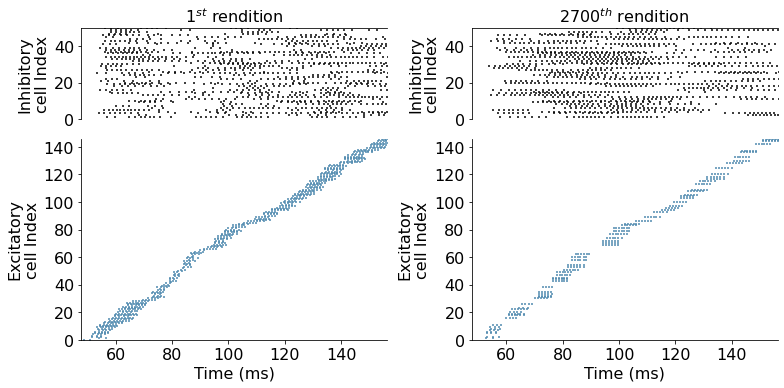

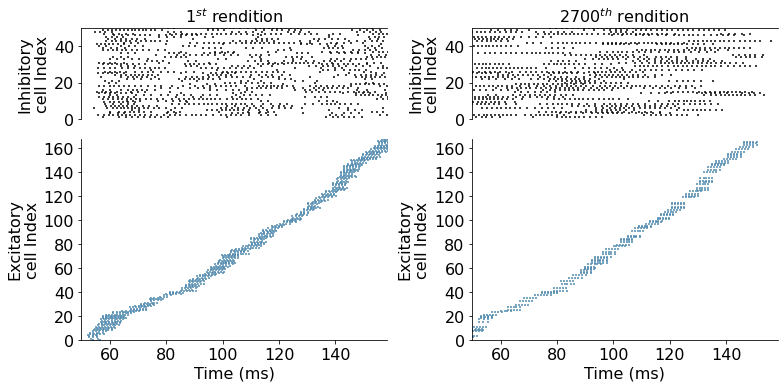

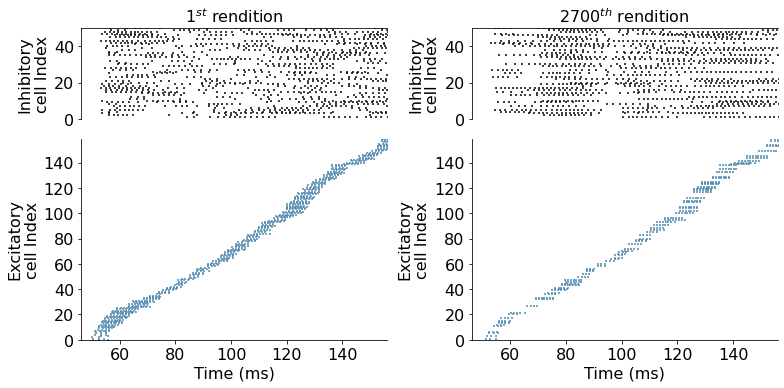

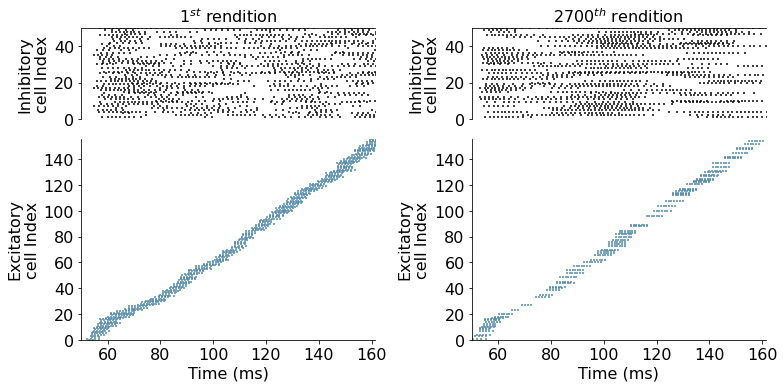

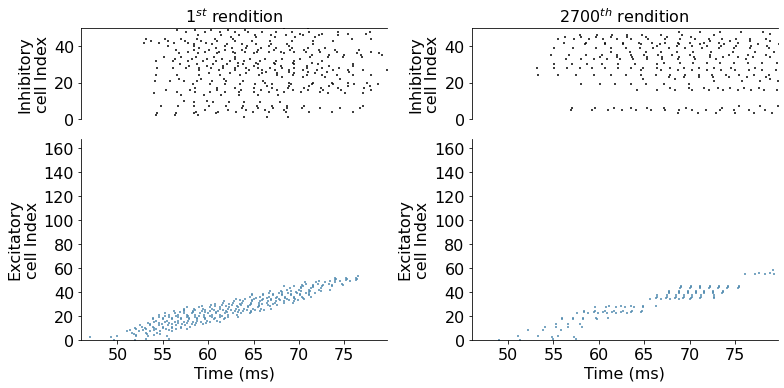

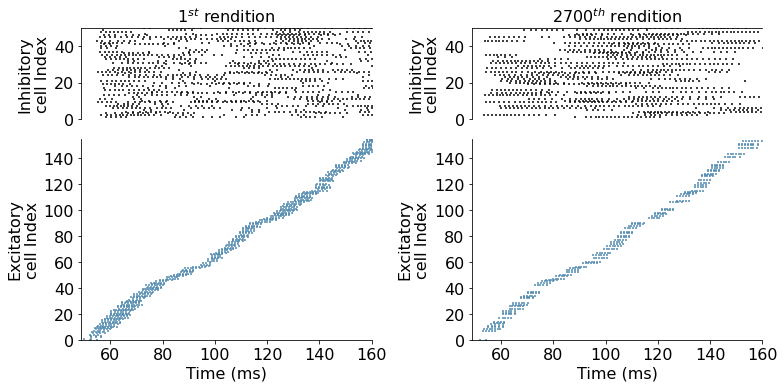

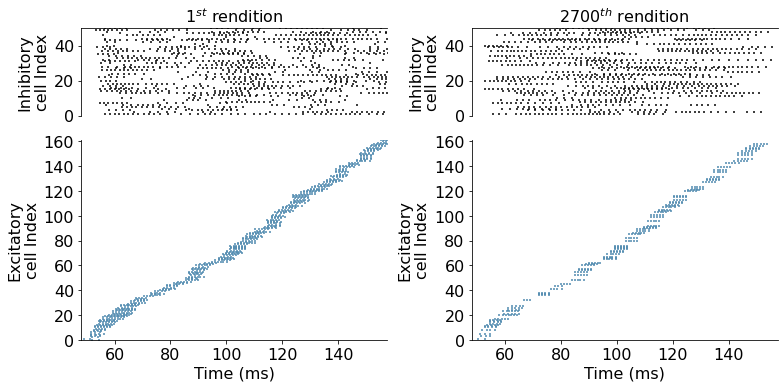

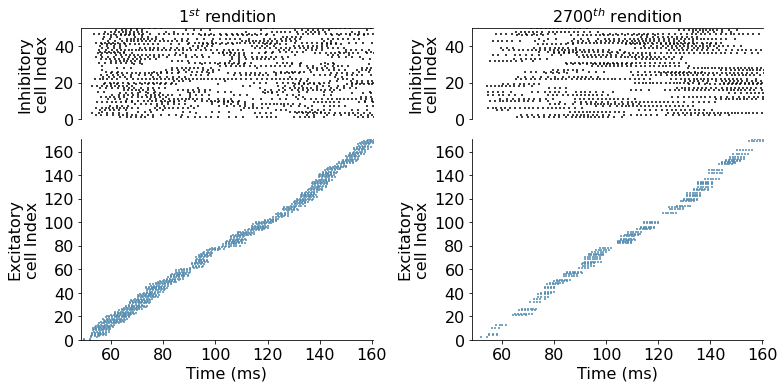

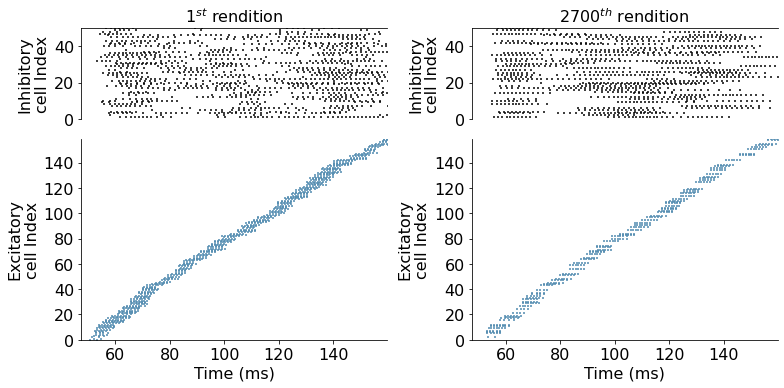

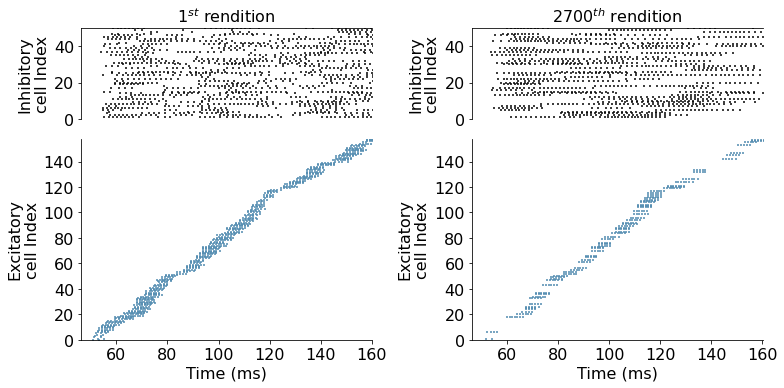

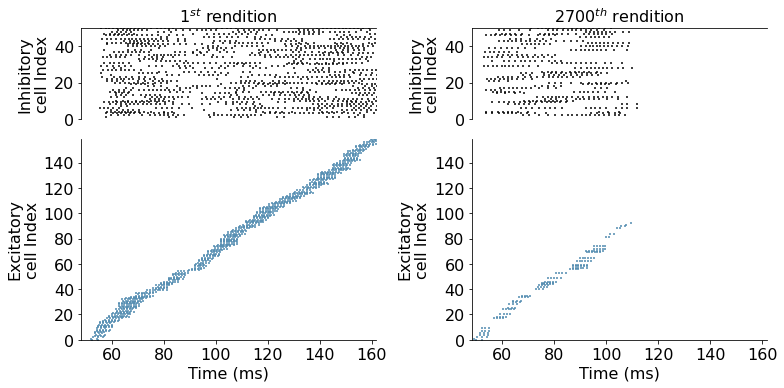

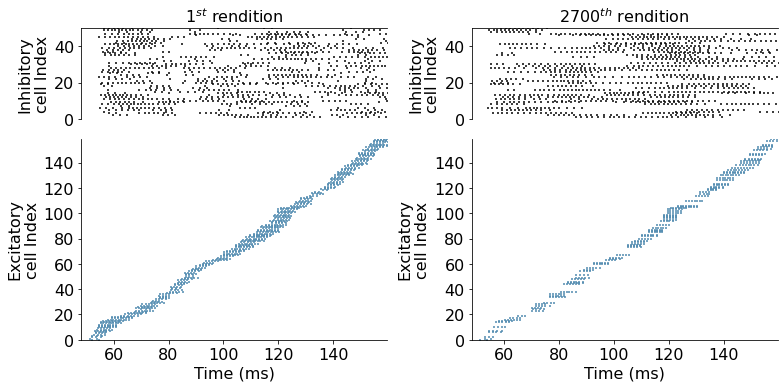

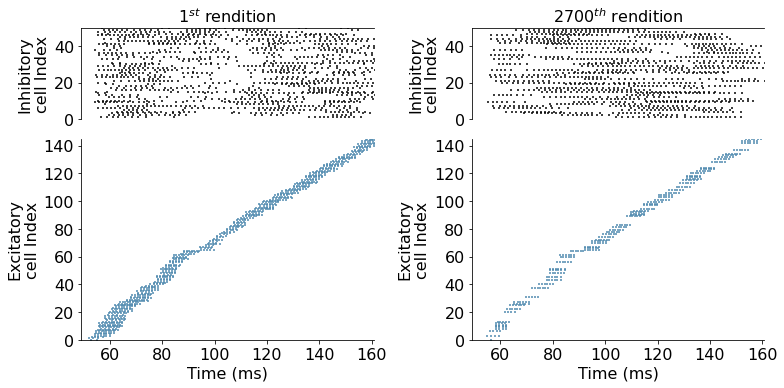

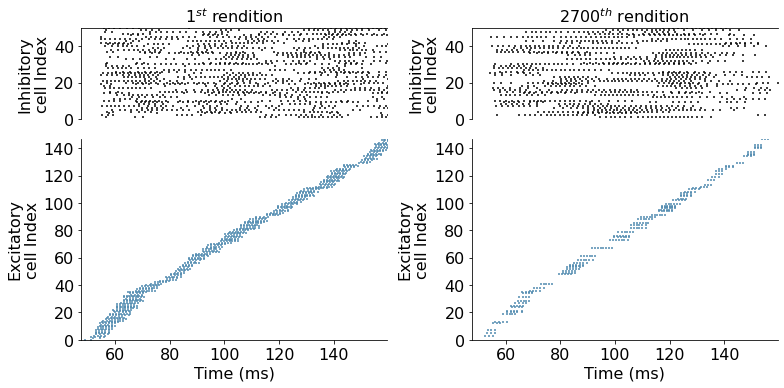

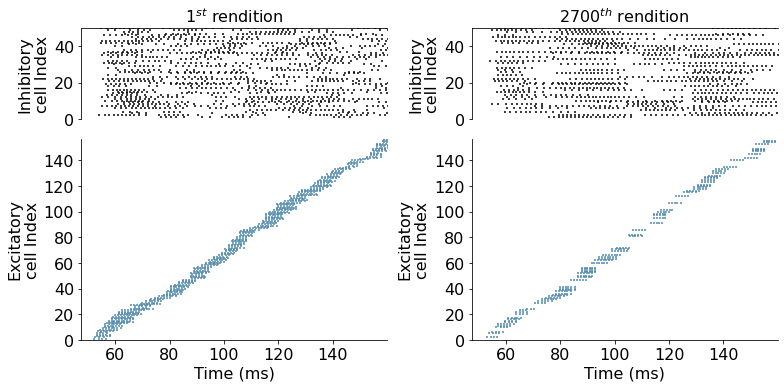

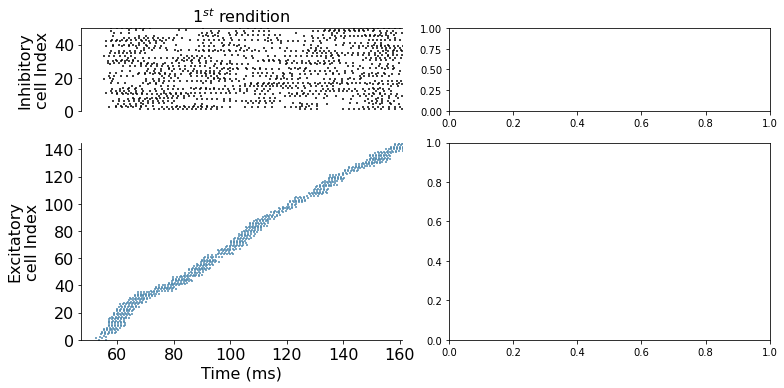

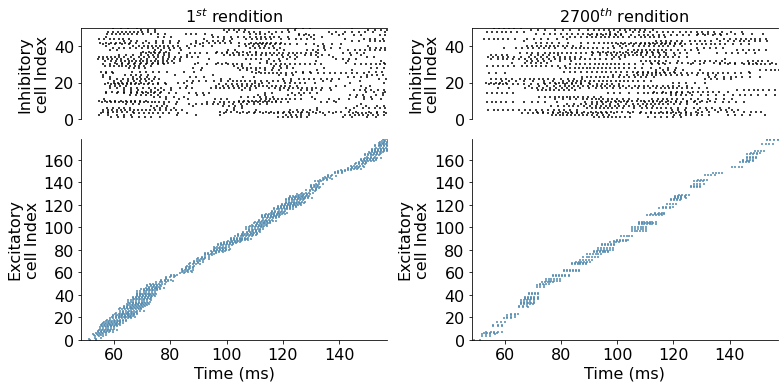

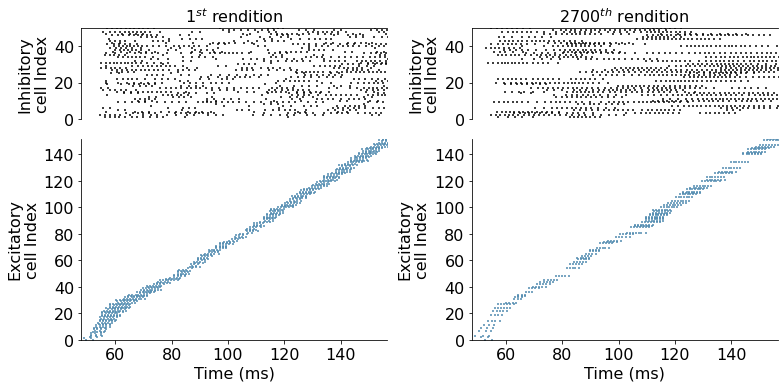

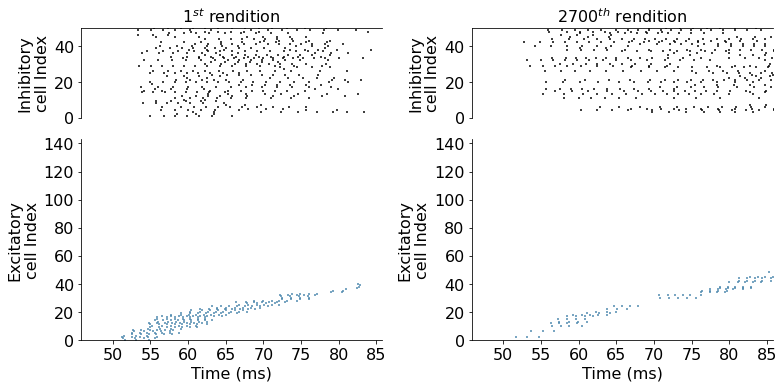

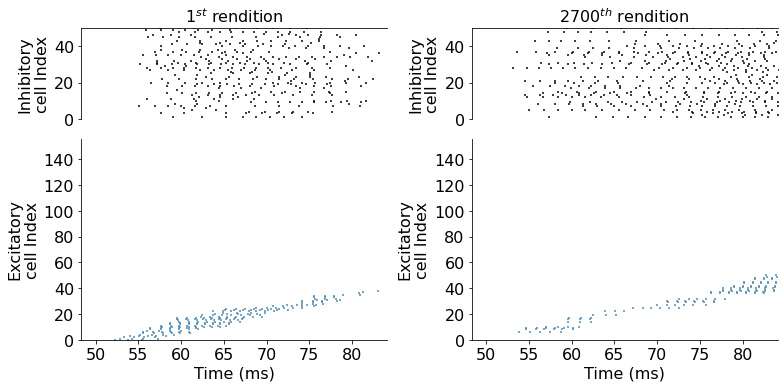

In [212]:
make_figure_1_sparse(single_fr, cell_range=(0, 800), shown_range=(0, 800), per_shown_per_layer=0.2, layer_size=10, timepoints=indices, color=colors_for_trials[3])

In [213]:
pop_fr_1 = ['uni_setpoint_long', 'GAMMA_0.01_']

uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
0
270


<ipython-input-60-e7a9213bee86>:114: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2061_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7565
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2062_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2403
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2063_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:0508
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2064_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:9046
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2065_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7623
0
270
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561
0
270
uni_setpoint_long__DROP_SEV_

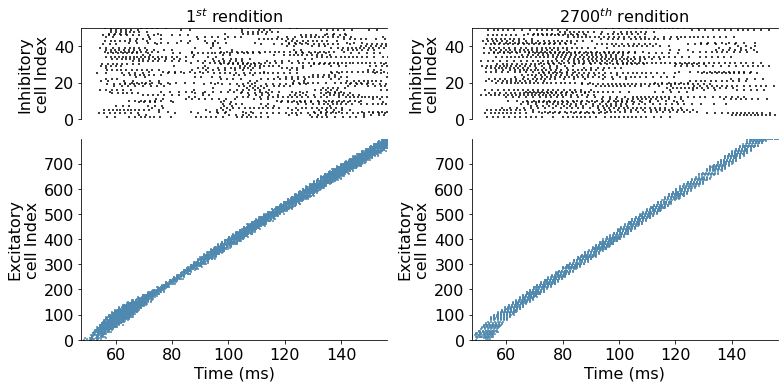

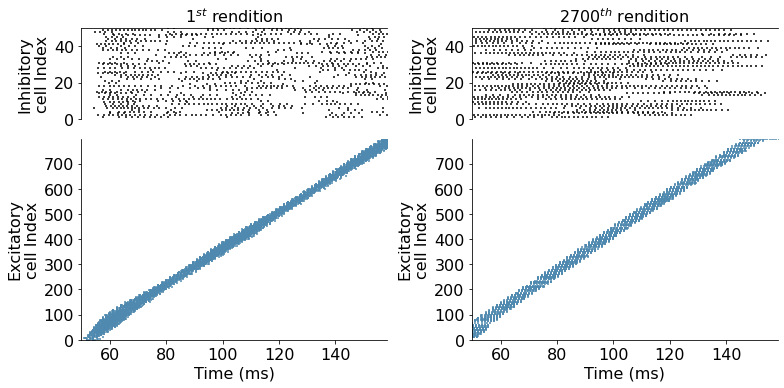

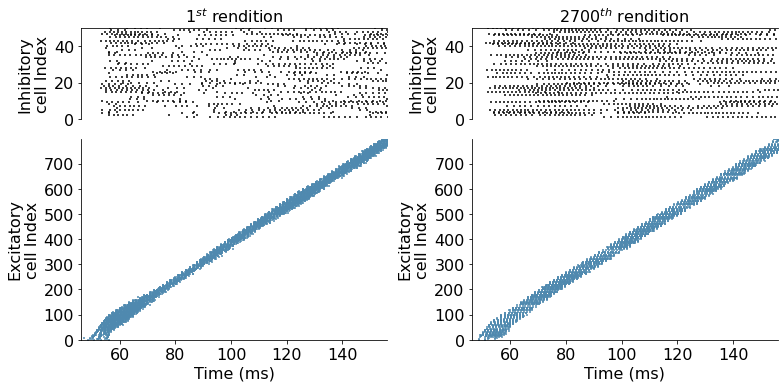

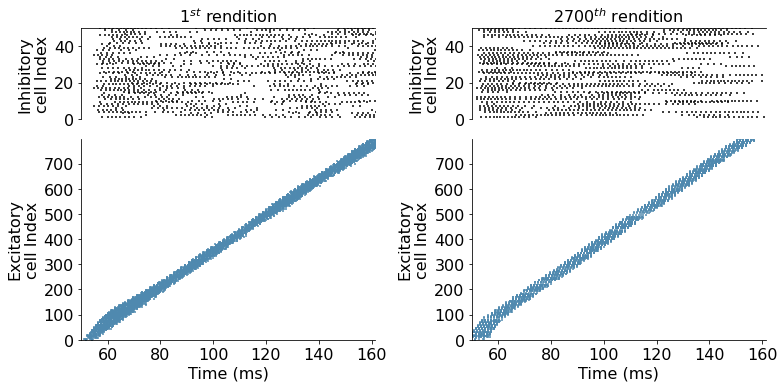

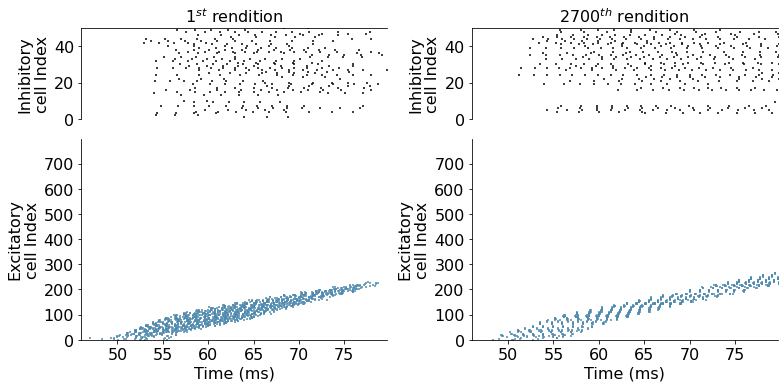

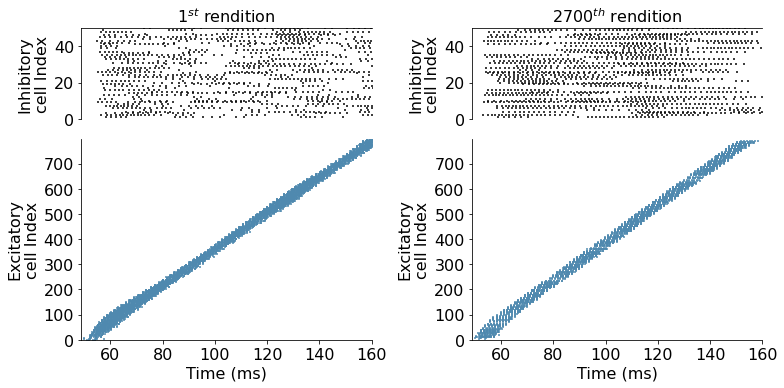

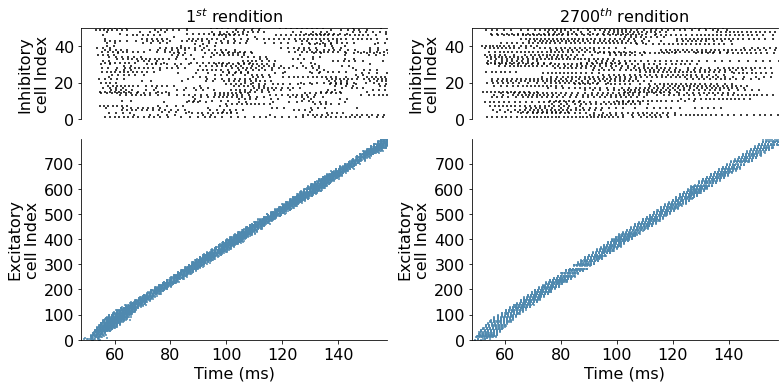

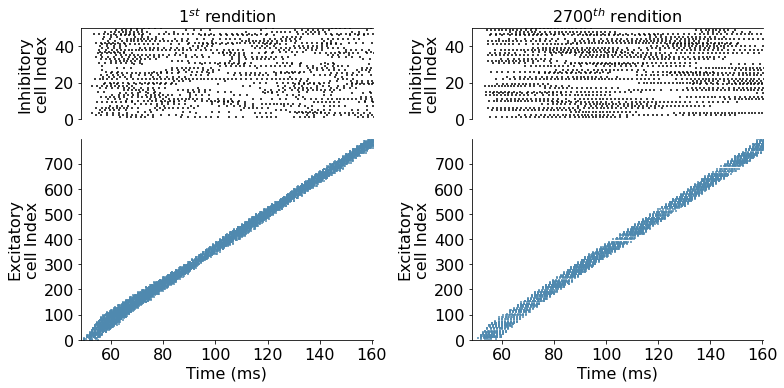

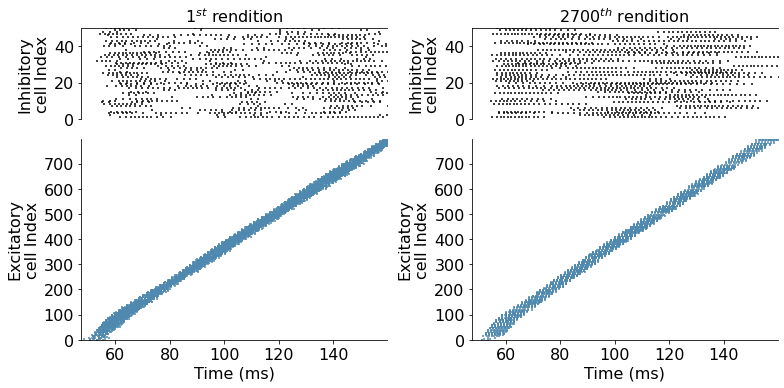

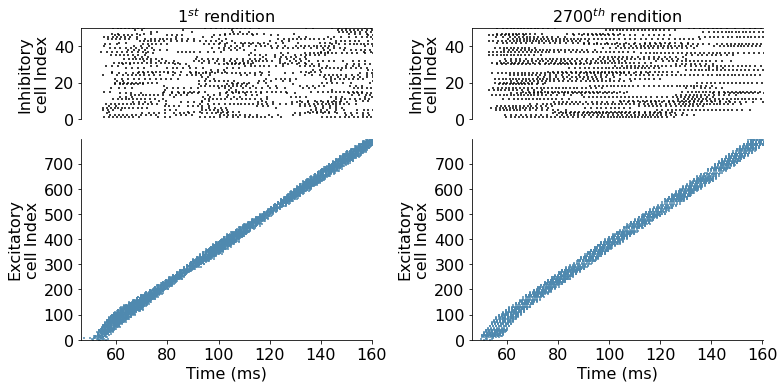

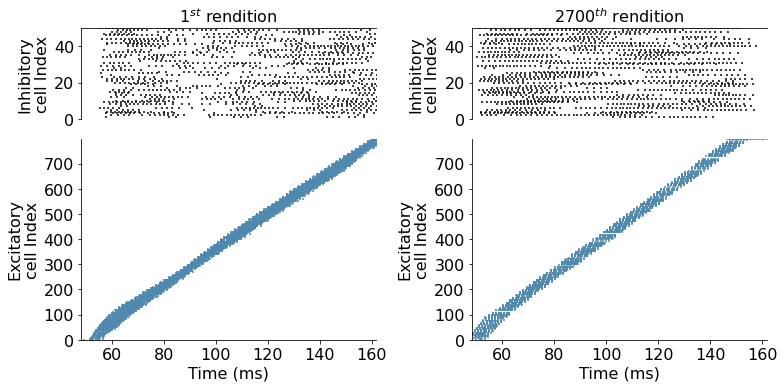

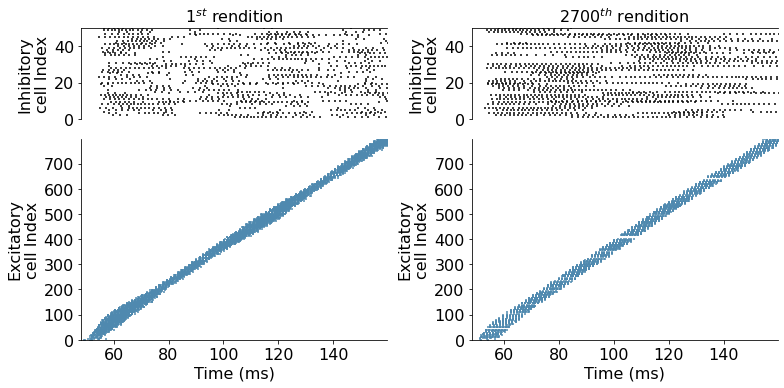

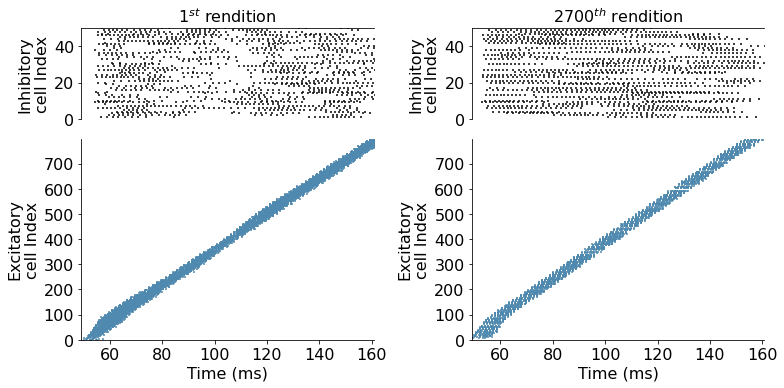

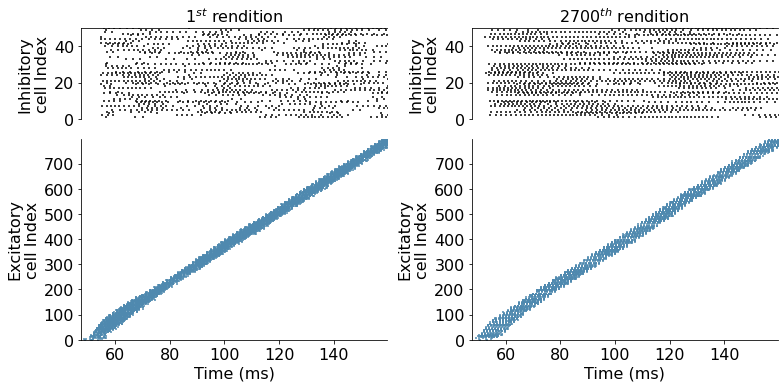

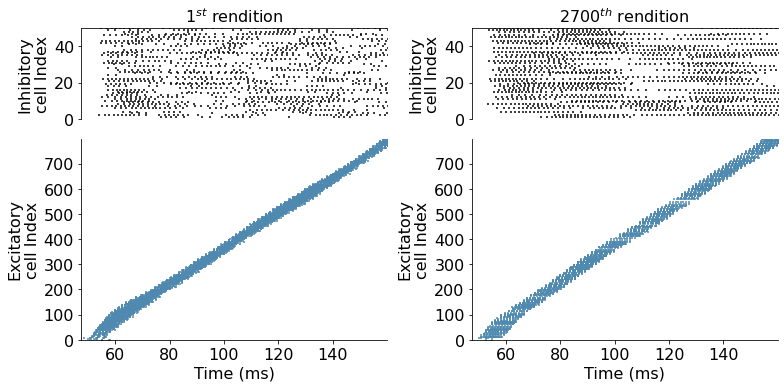

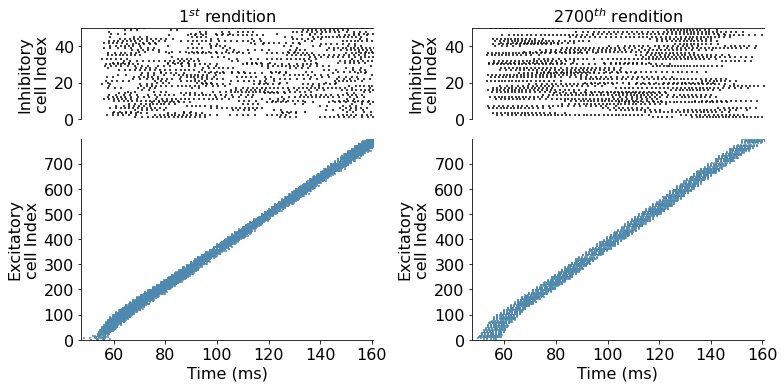

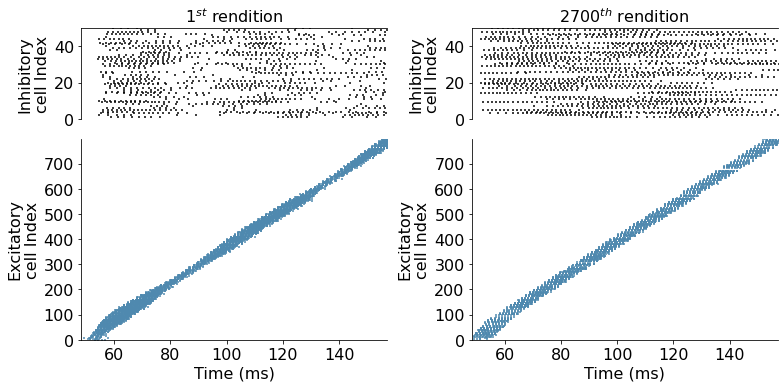

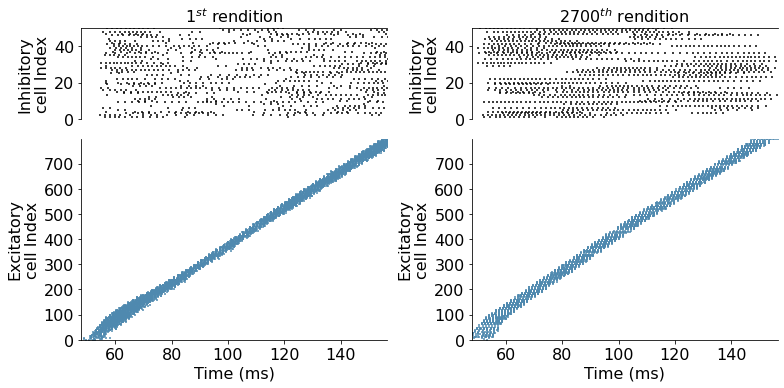

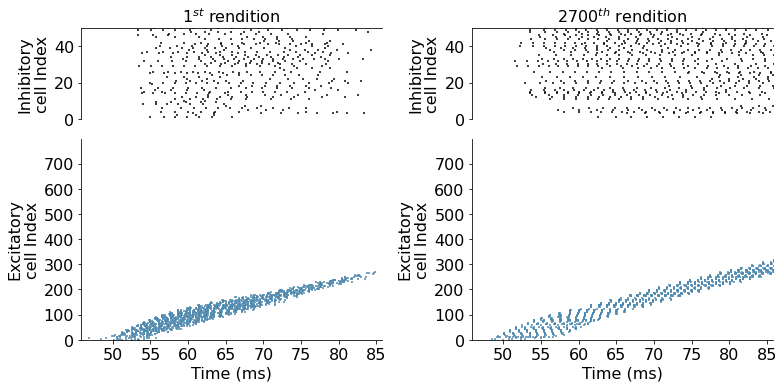

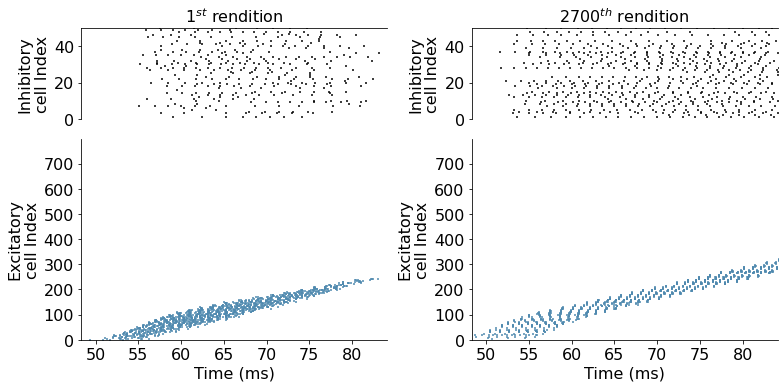

In [211]:
make_figure_1_sparse(pop_fr_1, cell_range=(0, 800), shown_range=(0, 800), per_shown_per_layer=1, layer_size=10, timepoints=indices, color=colors_for_trials[3])

In [10]:
def determine_recovered(names, timepoints, threshold=0.9):
    recovered_dir_names = []
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    all_recovery_pers = []
    for i, exp_dir_names in enumerate(all_dirs):
        per_recovered_for_name = 0
        for j, exp_dir_name in enumerate(exp_dir_names):
            print(exp_dir_name)
            n_active = 0
            n_count = 0
            last_layer_actives = []
            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                n_active += int((np.sum(data['layers_active'][-10:]) >= (0.7 * 10)) & np.any(data['first_spk_times'] > 0.15))
                n_count += 1
            if n_active == 0:
                continue
            print(n_active / n_count)
            if n_active / n_count >= threshold:
                print('X')
                recovered_dir_names.append(exp_dir_name)
                per_recovered_for_name += 1
        per_recovered_for_name /= len(exp_dir_names)
        all_recovery_pers.append(per_recovered_for_name)
        
    return recovered_dir_names, all_recovery_pers



In [11]:
def iter_range(r, n):
    if n == 1:
        yield (0, r[0])
    else:
        for i in range(n):
            yield (i, i * (r[1] - r[0]) / (n - 1) + r[0])

In [12]:
def real_to_str(real):
    s = f'{real}'
    first_sig_digit_idx = re.search('[1-9]', s)
    if not first_sig_digit_idx:
        return s
    
    x = s.rfind('00')
    while x >= 0 and x > first_sig_digit_idx.start():
        s = s[:x]
        x = s.rfind('00')
    return s

In [67]:
recovered_exp_names, all_recovery_pers = determine_recovered([
    single_fr,
    pop_fr_1
], np.arange(240, 270))

uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
1.0
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
1.0
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
0.9333333333333333
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
0.9
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
1.0
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621
0.9333333333333333
X
uni_setpoint_lon

0.7333333333333333
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2071_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7242
0.9333333333333333
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
0.9666666666666667
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
0.9666666666666667
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2065_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7623
0.8
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561
0.9
X
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2105_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5

0.8333333333333334


In [14]:
all_recovery_pers

[0.84]

In [15]:
# def inset_bar_plot(recovery_per, normed_final_activity_mean, normed_final_activity_mean_sem):
#     scale = 1
#     fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3 * scale, 2.5 * scale))
#     axs2 = axs.twinx()
#     axs.bar([0], [recovery_per, normed_final_activity_mean], width=0.5)
#     axs.bar([1], [recovery_per, normed_final_activity_mean], width=0.5)
#     axs.errorbar([1], [normed_final_activity_mean], yerr=normed_final_activity_mean_sem], color='none', ecolor='black', capsize=6)
#     axs.spines['top'].set_visible(False)
#     axs2.spines['top'].set_visible(False)
#     axs.yaxis.tick_left()
#     axs2.yaxis.tick_right()
#     axs.set_xticks([0, 1])
#     axs.set_xticklabels(['Percent\nrecovered', 'Normed\nrecovered\nactivity'])

In [295]:
def inset_bar_plot(recovery_per, normed_final_activity_mean, normed_final_activity_mean_sem, color='blue'):
    scale = 1
    fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3 * scale, 2.5 * scale))
    axs.bar([0, 1], [recovery_per * 100, normed_final_activity_mean * 100], width=0.5, color=color)
    axs.errorbar([1], [normed_final_activity_mean * 100], yerr=[normed_final_activity_mean_sem * 100], color='none', ecolor='black', capsize=6)
    axs.spines['top'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.set_xticks([0, 1])
    axs.set_xlim(-0.5, 1.5)
    axs.set_ylim(0, 100)
    axs.set_xticklabels(['Percent\nrecovered', 'Normalized\nrecovered\nactivity'])
    axs.yaxis.set_major_formatter(mtick.PercentFormatter())
    axs.yaxis.tick_right()
    set_font_size(axs, 14)

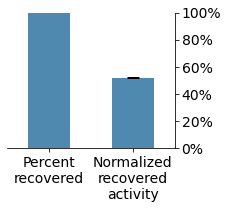

In [296]:
inset_bar_plot(1, 0.52, 0.004, color=colors_for_trials[3])

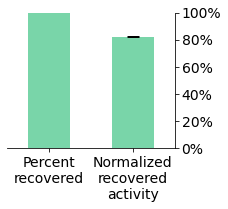

In [186]:
inset_bar_plot(1, 0.823, 0.0026, color=colors_for_trials[2])

In [16]:
def make_figure_2_plot(names, labels, condition_colors, file_name_ext='', ylim1=None, ylim2=None, ylabel1=None, ylabel2=None, timepoints=[], offsets=[], vertical_spacing=1., axs=None, fig=None, tick_right=True, legend=True):
    
    scale = 2.5
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6 * scale, 2.5 * scale))
    
    all_dirs = []
    for name in names:
        if type(name) is not list:
            name = [name]
        print(name)
        all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        
    timepoints = np.array(timepoints)
        
    for idx, exp_dir_names in enumerate(all_dirs):
        all_weights_for_dir_name = []
        all_weights_e_i_for_dir_name = []
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            if j > 5:
                continue
            print(exp_dir_name)
            
            all_mean_incoming_summed_weights = []
            all_std_incoming_summed_weights = []
            all_mean_incoming_summed_weights_e_i = []
            all_std_incoming_summed_weights_e_i = []
            baseline_mean = None
            baseline_std = None
            baseline_mean_e_i = None
            baseline_std_e_i = None

            for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if i not in timepoints:
                    continue
                data = data_load()
                
                all_mean_incoming_summed_weights.append(data['mean_incoming_summed_weights'])
                all_std_incoming_summed_weights.append(data['std_incoming_summed_weights'])
                all_mean_incoming_summed_weights_e_i.append(data['mean_incoming_summed_weights_e_i'])
                all_std_incoming_summed_weights_e_i.append(data['std_incoming_summed_weights_e_i'])

                if i == offsets[idx]:
                    baseline_mean = data['mean_incoming_summed_weights']
                    baseline_std = data['std_incoming_summed_weights']
                    baseline_mean_e_i = data['mean_incoming_summed_weights_e_i']
                    baseline_std_e_i = data['std_incoming_summed_weights_e_i']
                       
            all_mean_incoming_summed_weights = np.array(all_mean_incoming_summed_weights) / baseline_mean
            all_std_incoming_summed_weights = np.array(all_std_incoming_summed_weights) / baseline_mean
            all_mean_incoming_summed_weights_e_i = np.array(all_mean_incoming_summed_weights_e_i) / baseline_mean_e_i
            all_std_incoming_summed_weights_e_i = np.array(all_std_incoming_summed_weights_e_i) / baseline_mean_e_i
                
            all_weights_for_dir_name.append(all_mean_incoming_summed_weights)
            all_weights_e_i_for_dir_name.append(all_mean_incoming_summed_weights_e_i)
            
#             axs[0].plot(timepoints[:len(all_mean_incoming_summed_weights)] * 10, all_mean_incoming_summed_weights, color='black', lw=0.5, zorder=-1)
#             axs[1].plot(timepoints[:len(all_mean_incoming_summed_weights_e_i)] * 10, all_mean_incoming_summed_weights_e_i, color='black', lw=0.5, zorder=-1)

        
        if len(all_weights_for_dir_name) == 0:
            continue
        
        e_e_means = safe_apply_stat(all_weights_for_dir_name, np.mean)
        e_e_sems = safe_apply_stat(all_weights_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))
        e_i_means = safe_apply_stat(all_weights_e_i_for_dir_name, np.mean)
        e_i_sems = safe_apply_stat(all_weights_e_i_for_dir_name, lambda x: np.std(x) / np.sqrt(len(x)))

        y_disp = vertical_spacing * idx

        axs[0].fill_between(
            timepoints * 10,
            e_e_means - e_e_sems + y_disp,
            e_e_means + e_e_sems + y_disp,
            color=condition_colors[idx][0], alpha=0.2, zorder=0)
        axs[0].plot(timepoints * 10, e_e_means + y_disp, lw=1.5, color=condition_colors[idx][0], label=labels[idx], zorder=0)
        axs[1].fill_between(
            timepoints * 10,
            e_i_means - e_i_sems + y_disp,
            e_i_means + e_i_sems + y_disp,
            color=condition_colors[idx][1], alpha=0.2, zorder=-1)
        axs[1].plot(timepoints * 10, e_i_means + y_disp, lw=1.5, color=condition_colors[idx][1], label=labels[idx], zorder=-1)

        if ylabel1 is None:    
            axs[0].set_ylabel(r'Mean E$\rightarrow$E summed' + '\nsynapse strength')
        else:
            axs[0].set_ylabel(ylabel1)
            
        if ylabel2 is None:  
            axs[1].set_ylabel(r'Mean E$\rightarrow$I summed' + '\nsynapse strength')
        else:
            axs[1].set_ylabel(ylabel2)
        if ylim1 is not None:
                axs[0].set_ylim(ylim1[0], ylim1[1])
        if ylim2 is not None:
                axs[1].set_ylim(ylim2[0], ylim2[1])
                
        y_ticks = []
        y_tick_labels = []
        for i in range(len(names)):
            y_ticks.append(vertical_spacing * i + 0.5)
            y_ticks.append(vertical_spacing * i + 1)
            y_ticks.append(vertical_spacing * i + 1.5)
            y_tick_labels.append(0.5)
            y_tick_labels.append(1)
            y_tick_labels.append(1.5)
                
        for i in range(2):
            axs[i].set_xlabel('Rendition number')
            if tick_right:
                axs[i].tick_params(right=True, labelright=True)
        
#             axs[i].set_yticks(y_ticks)
#             axs[i].set_yticklabels(y_tick_labels)
    if legend:
        axs[0].legend(loc='lower right')
    fig.tight_layout()
    save_fig(fig, './figures/paper/fig_2', f'mean_plot_{file_name_ext}.png')

['uni_setpoint_long', 'GAMMA_0_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621


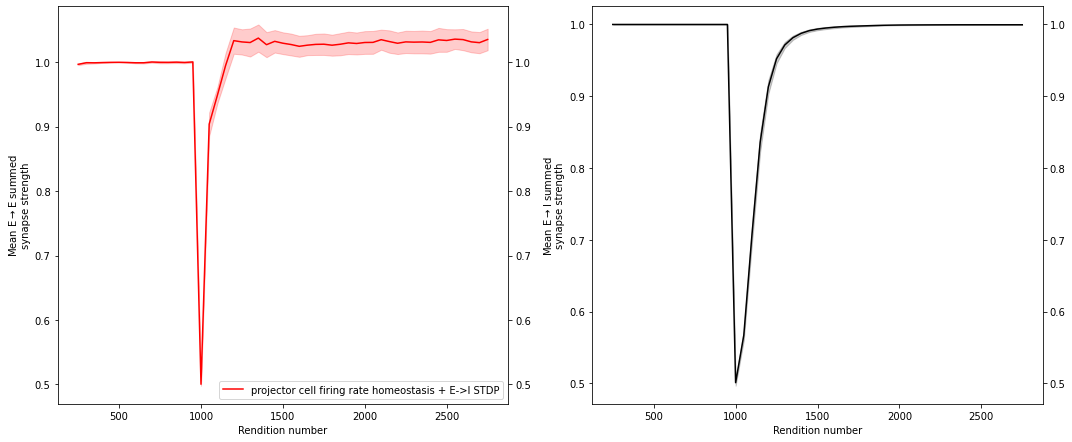

In [17]:
timepoints = np.arange(25, 280, 5)

make_figure_2_plot([
    single_fr,
], labels=[
    'projector cell firing rate homeostasis + E->I STDP',
], condition_colors=[['red', 'black']], timepoints=timepoints, offsets=np.ones(3) * 50, vertical_spacing=0.,
file_name_ext='all_3_silent')

In [17]:
recovered_exp_names = [x.strip() for x in recovered_exp_names]


In [18]:
def extract_weight_dist_stats(names, recovered_exp_names, timepoints):
    all_dirs = []
    for name in names:
        if type(names) is list:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)])
        else:
            all_dirs.append([dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), [name])])
    
    all_weight_dist_info = []
    all_summed_weights = []
    
    for i, exp_dir_names in enumerate(all_dirs):
        
        summed_weights_for_group = [[] for t in timepoints]
        weight_freqs_for_group = [[] for t in timepoints]
        weight_bins = [[] for t in timepoints]
        
        for j, exp_dir_name in enumerate(exp_dir_names):
            if exp_dir_name not in recovered_exp_names:
                continue
            print(exp_dir_name)
            
            t_ctr = 0
            for k, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name), name_frags=[]):
                if k not in timepoints:
                    continue
                data = data_load()
                
                summed_incoming_weights = data['summed_incoming_weights']
                summed_weights_for_group[t_ctr].append(summed_incoming_weights)
                
                bins, freqs = bin_occurrences(summed_incoming_weights, max_val=0.0035, bin_size=0.00001)
                weight_bins[t_ctr] = bins
                weight_freqs_for_group[t_ctr].append(freqs)
                
                t_ctr += 1
        
        mean_weight_dists = []
        std_weight_dists = []
        summed_weight_bins = []
        
        mean_summed_incoming_weights = []
        std_summed_incoming_weights = []
        all_summed_incoming_weights = []
        
        for i_t, t in enumerate(timepoints):
            mean_weight_dists.append(np.nanmean(weight_freqs_for_group[i_t], axis=0))
            std_weight_dists.append(np.nanstd(weight_freqs_for_group[i_t], axis=0))
            summed_weight_bins.append(weight_bins[i_t])
            
            all_summed_incoming_weights.append(np.array(summed_weights_for_group[i_t]).flatten())
            mean_summed_incoming_weights.append(np.nanmean(summed_weights_for_group[i_t], axis=0).flatten())
            std_summed_incoming_weights.append(np.nanstd(summed_weights_for_group[i_t], axis=0).flatten())
                
        all_weight_dist_info.append({
            'mean_weight_dists': mean_weight_dists,
            'std_weight_dists': std_weight_dists,
            'summed_weight_bins': summed_weight_bins[0],
            'mean_summed_incoming_weights': mean_summed_incoming_weights,
            'std_summed_incoming_weights': std_summed_incoming_weights,
            'all_summed_incoming_weights': all_summed_incoming_weights,
        })
    return all_weight_dist_info

In [98]:
all_weight_dist_info_1 = extract_weight_dist_stats([
    single_fr,
], recovered_exp_names, [60, 105, 160])

uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2069_ALPHA_2_0.005_ALPHA_1_0.03_FR

In [99]:
pickle.dump(all_weight_dist_info_1, open('parsed_data_3.p', 'wb'))


In [172]:
def make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info, name, dist_timepoints):
    scale = 1.3
    fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))

    dist_timepoints = np.array(dist_timepoints)
    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
            mean_initial_summed_incoming_weight = np.mean(dist_data_for_name['all_summed_incoming_weights'][0])
            widths = 160
            parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'] / mean_initial_summed_incoming_weight, positions=dist_timepoints * 10, showmeans=False, showextrema=False, widths=widths)
            for pc in parts['bodies']:
                pc.set_facecolor('red')
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)
        
            axs.set_ylim(0, 4.5)
            axs.set_xlim((dist_timepoints[0] - 10) * 10, (dist_timepoints[-1] + 10) * 10)

            num_to_sample = 1000
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(dist_data))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                axs.scatter(dist_timepoints[i] * 10 + 1 + np.random.normal(size=num_to_sample, scale=15), dist_data[indices_to_show] / mean_initial_summed_incoming_weight, s=2, color='red', zorder=3)
            axs.set_xticks(dist_timepoints * 10)
            axs.set_xticklabels([
                r'$1^{st}$' + '\nrendition',
                r'$50^{th}$' + '\nrendition',
                r'$2700^{th}$'  + '\nrendition'
            ])
            axs.set_ylabel('Excitatory summed synaptic strength')
            axs.spines['top'].set_visible(False)
            axs.spines['right'].set_visible(False)

            timepoints = np.arange(dist_timepoints[0] - 10, dist_timepoints[-1] + 10)

            make_figure_2_plot([
                name,
            ], labels=[
                '',
            ], condition_colors=[('red', 'black')], timepoints=timepoints, offsets=dist_timepoints[0] * np.ones(3), vertical_spacing=0.,
            file_name_ext='all_3_silent', axs=[axs, axs], fig=fig, tick_right=False, legend=False, ylabel2='Mean normed\nsummed synapse\nstrength')
            set_font_size(axs, 14)
            
            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')
            
        
#         axs[k, 0].set_ylim(0, 0.0015)
#         bins = dist_data_for_name['summed_weight_bins']
#         for i_t, means in enumerate(dist_data_for_name['mean_weight_dists']):
#             stds = dist_data_for_name['std_weight_dists'][i_t]
            
#             axs[k, 1].fill_between(bins, means - stds, means + stds, color=colors[i_t], alpha=0.2)
#             axs[k, 1].plot(bins, means, color=colors[i_t])

        
        
# fig.tight_layout()

['uni_setpoint_long', 'GAMMA_0_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621


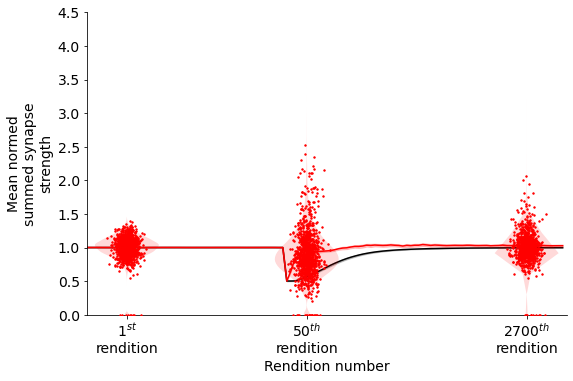

In [173]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_1, single_fr, [60, 105, 160])

['uni_setpoint_long', 'GAMMA_0.01_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2071_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7242
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561


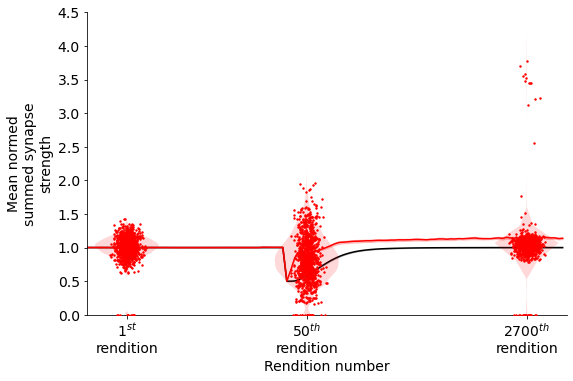

In [174]:
make_interpolated_violin_plot_and_weight_traj(all_weight_dist_info_pop_1, pop_fr_1, [60, 105, 160])

In [175]:
def make_violin_plot_with_inset(all_weight_dist_info, name):
    scale = 1.3
    fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(6 * scale, 4 * scale))

    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
    #         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])
            parts = axs.violinplot(dist_data_for_name['all_summed_incoming_weights'], showmeans=False, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor('red')
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)

            num_to_sample = 1000
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(dist_data))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                if num_to_sample > len(dist_data):
                    num_to_sample = len(dist_data)
                axs.scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show], s=1, color='red')
            axs.set_xticks([1, 2, 3])
            axs.set_xticklabels([
                r'$1^{st}$' + '\nrendition\n(unperturbed)',
                r'$50^{th}$' + '\nrendition\n(perturbed)',
                r'$2700^{th}$'  + '\nrendition\n(recovered)'
            ])
            axs.set_ylabel('Excitatory summed synaptic strength')
            axs.spines['top'].set_visible(False)
            axs.spines['right'].set_visible(False)
            axs.set_ylim(0, 0.005)
            set_font_size(axs, 14)

            axs_ins = inset_axes(axs, width='40%', height='40%',
                                 bbox_transform=axs.transAxes,
                                 bbox_to_anchor=(.35, -0.03, 1, 1), loc='upper left')

            axs_ins.spines['top'].set_visible(False)
            axs_ins.spines['right'].set_visible(False)

            axs_ins.tick_params(right=False, labelright=False)
            axs_ins.set_ylim(0, 1.5)

            timepoints = np.arange(0, 200, 1)

            make_figure_2_plot([
                name,
            ], labels=[
                '',
            ], condition_colors=[('red', 'black')], timepoints=timepoints, offsets=np.zeros(3), vertical_spacing=0.,
            file_name_ext='all_3_silent', axs=[axs_ins, axs_ins], fig=fig, tick_right=False, legend=False, ylabel2='Mean normed\nsummed synapse\nstrength')
            set_font_size(axs, 8)

            axs_ins.tick_params(right=False, labelright=False)

            save_fig(fig, './figures/paper/weight_trajectories', f'{k}.svg')

['uni_setpoint_long', 'GAMMA_0_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621


<ipython-input-16-aa8f6af41d53>:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


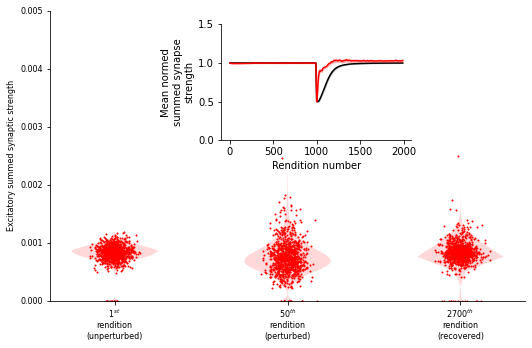

In [176]:
make_violin_plot_with_inset(all_weight_dist_info_1, single_fr)

In [141]:
all_weight_dist_info_pop_1 = extract_weight_dist_stats([
    pop_fr_1,
], recovered_exp_names, [60, 102, 160])

uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2071_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7242
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2105_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--41:9637
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2086_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:8208
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2074_ALPHA_2_0.0

['uni_setpoint_long', 'GAMMA_0.01_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2071_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7242
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561


<ipython-input-16-aa8f6af41d53>:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


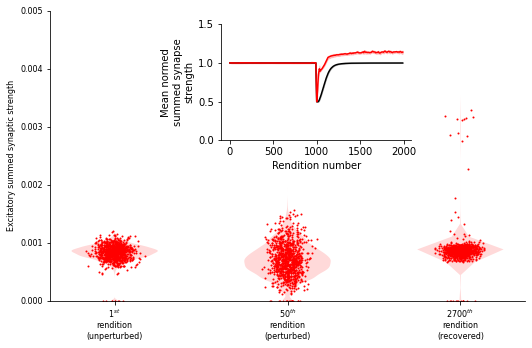

In [177]:
make_violin_plot_with_inset(all_weight_dist_info_pop_1, pop_fr_1)

In [143]:
def make_violin_plot_separate_weight_traj(all_weight_dist_info, name):
    scale = 1.3
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10 * scale, 4 * scale))

    colors = get_equally_spaced_colors(3, cmap='winter')

    for k, dist_data_for_name in enumerate(all_weight_dist_info):
        if len(dist_data_for_name) > 0:
    #         widths = np.array([np.max(d) for d in dist_data_for_name['mean_weight_dists']])
            axs[1].set_ylabel('Summed synaptic strength')
            axs[1].yaxis.set_label_position('right')
            axs[1].yaxis.tick_right()
    #         axs[1].tick_params(right=True, labelright=True, left=False, labelleft=False)
            parts = axs[1].violinplot(dist_data_for_name['all_summed_incoming_weights'], showmeans=False, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor('red')
    #             pc.set_edgecolor('black')
                pc.set_alpha(0.15)

            num_to_sample = 1000
            for i, dist_data in enumerate(dist_data_for_name['all_summed_incoming_weights']):
                indices_to_show = np.arange(len(dist_data))
                np.random.shuffle(indices_to_show)
                indices_to_show = indices_to_show[:num_to_sample]
                axs[1].scatter(i + 1 + np.random.normal(size=num_to_sample, scale=0.05), dist_data[indices_to_show], s=1, color='red')
            axs[1].set_xticks([1, 2, 3])
            axs[1].set_xticklabels([
                r'$1^{st}$' + '\nrendition',
                r'$50^{th}$' + '\nrendition',
                r'$2700^{th}$'  + '\nrendition'
            ])
            set_font_size(axs[1], 14)
            axs[1].set_ylim(0, 0.005)

            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['left'].set_visible(False)

            timepoints = np.arange(0, 200, 1)
            axs[0].set_ylim(0, 1.5)

            make_figure_2_plot([
                name,
            ], labels=[
                '',
            ], condition_colors=[('red', 'black')], timepoints=timepoints, offsets=np.zeros(3), vertical_spacing=0.,
            file_name_ext='all_3_silent', axs=[axs[0], axs[0]], fig=fig, tick_right=False, legend=False, ylabel2='Normed summed\nsynapse strength')
            

            set_font_size(axs[0], 14)
            save_fig(fig, './figures/paper/weight_trajectories_wide', f'{k}.svg')
    fig.tight_layout()

['uni_setpoint_long', 'GAMMA_0_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2068_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7863
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2103_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:6747
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2072_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:5866
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2080_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:2820
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2091_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7621


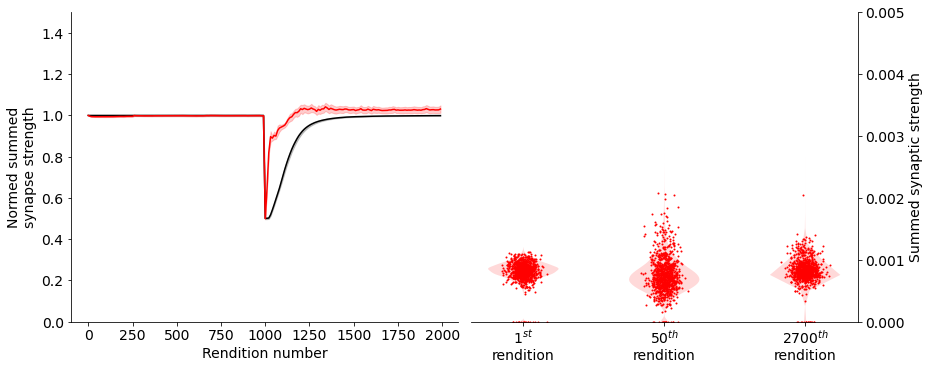

In [181]:
make_violin_plot_separate_weight_traj(all_weight_dist_info_1, single_fr)

['uni_setpoint_long', 'GAMMA_0.01_']
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2071_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:7242
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2060_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1801
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2108_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--40:9700
uni_setpoint_long__DROP_SEV_0.5_BETA_0.002_SEED_2066_ALPHA_2_0.005_ALPHA_1_0.03_FR_LINE_ATTR_1_GAMMA_0.01_ff_1.0_eir_8.3_ier_0.5_2022-01-25--16:59--29:1561


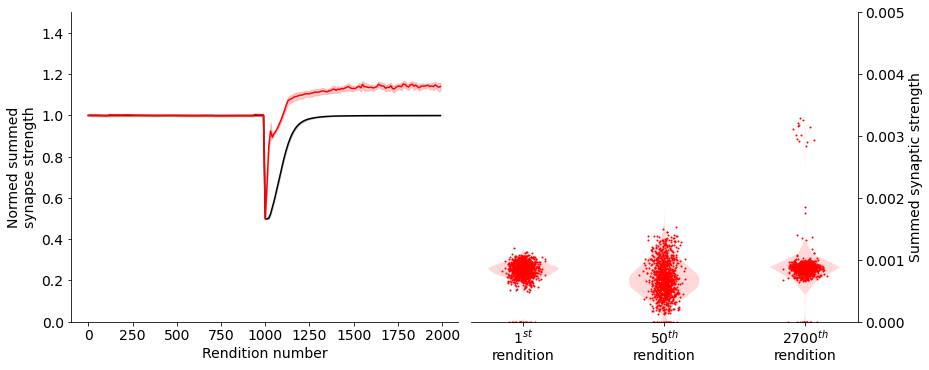

In [178]:
make_violin_plot_separate_weight_traj(all_weight_dist_info_pop_1, pop_fr_1)

In [204]:
def make_figure_3b(name, ylim=(0, 8), initial_timepoint_range=(0, 4), final_timepoint_range=(170, 180), color='blue'):    
    all_dirs = [dirs for dirs in filter_list_by_name_frags(all_in_dir('./robustness'), name)]
            
    labels = [
        'unperturbed',
        '900th rendition',
    ]
    
    scale = 1.9
    fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(3 * scale, 3 * scale))
    
    firing_rate_stats_initial = {
        'spk_bins_e': None,
        'freqs_e': [],
        'spk_bins_i': None,
        'freqs_i': [],
    }
    firing_rate_stats_final = copy(firing_rate_stats_initial)
           
    for idx, exp_dir_name in enumerate(all_dirs):
        for i, data_load in load_exp_data(os.path.join('./robustness', exp_dir_name)):
            if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]) or (i >= final_timepoint_range[0] and i <= final_timepoint_range[1]):
                    data = data_load()

                    spk_bins_e = data['spk_bins']
                    freqs_e = data['freqs']
                    spks_for_i_cells = data['inh_raster']
                    
                    if len(spks_for_i_cells) > 0:
                        spks_for_i_cells = spks_for_i_cells[1]
                        cell_labels, spks_i = bin_occurrences(spks_for_i_cells, min_val=800, max_val=1000, bin_size=1)
                        spk_bins_i, freqs_i = bin_occurrences(spks_i, max_val=100, bin_size=1)
                    else:
                        spk_bins_i, freqs_i = (np.zeros(100), np.zeros(100))
                        
                    if (i >= initial_timepoint_range[0] and i <= initial_timepoint_range[1]):
                        firing_rate_stats = firing_rate_stats_initial
                    else:
                        firing_rate_stats = firing_rate_stats_final
                        
                    if firing_rate_stats['spk_bins_e'] is None:
                        firing_rate_stats['spk_bins_e'] = spk_bins_e
                    if firing_rate_stats['spk_bins_i'] is None:
                        firing_rate_stats['spk_bins_i'] = spk_bins_i
                    firing_rate_stats['freqs_e'].append(freqs_e)
                    firing_rate_stats['freqs_i'].append(freqs_i)
        
    for firing_rate_stats in [firing_rate_stats_initial, firing_rate_stats_final]:
        firing_rate_stats['freqs_e'] = (np.mean(np.stack(firing_rate_stats['freqs_e']), axis=0), np.std(np.stack(firing_rate_stats['freqs_e']), axis=0))
        firing_rate_stats['freqs_i'] = (np.mean(np.stack(firing_rate_stats['freqs_i']), axis=0), np.std(np.stack(firing_rate_stats['freqs_i']), axis=0))

    freqs_e_initial_low = firing_rate_stats_initial['freqs_e'][0] - firing_rate_stats_initial['freqs_e'][1]
    freqs_e_initial_high = firing_rate_stats_initial['freqs_e'][0] + firing_rate_stats_initial['freqs_e'][1]
    # axs[0].fill_between(firing_rate_stats_initial['spk_bins_e'], y1=freqs_e_initial_low, y2=freqs_e_initial_high, color='gray', alpha=0.4, zorder=-1)
    axs[0].plot(firing_rate_stats_initial['spk_bins_e'], firing_rate_stats_initial['freqs_e'][0], color='gray', alpha=1., zorder=-1, lw=1.2, label=labels[0])
    
    freqs_i_initial_low = firing_rate_stats_initial['freqs_i'][0] - firing_rate_stats_initial['freqs_i'][1]
    freqs_i_initial_high = firing_rate_stats_initial['freqs_i'][0] + firing_rate_stats_initial['freqs_i'][1]
    # axs[1].fill_between(firing_rate_stats_initial['spk_bins_i'], y1=freqs_i_initial_low, y2=freqs_i_initial_high, color='gray', alpha=0.4, zorder=-1)
    axs[1].plot(firing_rate_stats_initial['spk_bins_i'], firing_rate_stats_initial['freqs_i'][0], '--', color='gray', alpha=1., zorder=-1, lw=1.2, label=labels[0] + ' inh')

    freqs_e_final_low = firing_rate_stats_final['freqs_e'][0] - firing_rate_stats_final['freqs_e'][1]
    freqs_e_final_high = firing_rate_stats_final['freqs_e'][0] + firing_rate_stats_final['freqs_e'][1]
    # axs[0].fill_between(firing_rate_stats_final['spk_bins_e'], y1=freqs_e_final_low, y2=freqs_e_final_high, color='red', alpha=0.4, zorder=-1)
    axs[0].plot(firing_rate_stats_final['spk_bins_e'], firing_rate_stats_final['freqs_e'][0], color='red', alpha=1., zorder=0, lw=1.2, label=labels[1]) 
    
    freqs_i_final_low = firing_rate_stats_final['freqs_i'][0] - firing_rate_stats_final['freqs_i'][1]
    freqs_i_final_high = firing_rate_stats_final['freqs_i'][0] + firing_rate_stats_final['freqs_i'][1]
    # axs[1].fill_between(firing_rate_stats_final['spk_bins_i'], y1=freqs_i_final_low, y2=freqs_i_final_high, color='red', alpha=0.4, zorder=-1)
    axs[1].plot(firing_rate_stats_final['spk_bins_i'], firing_rate_stats_final['freqs_i'][0], '--', color='red', alpha=1., zorder=0, lw=1.2, label=labels[1] + ' inh')

    axs[1].set_xlabel('Spikes per rendition')
    axs[0].set_ylabel('Excitatory counts')
    axs[1].set_ylabel('Inhibitory counts')
    axs[0].set_xlim(1, 10)
    axs[1].set_xlim(1, 60)
    axs[0].spines['top'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
#     axs[0].set_ylim(0, 175)
    axs[1].set_ylim(0)

    axs[0].legend(frameon=False)

    set_font_size(axs[0], 15)
    set_font_size(axs[1], 15)

    plt.locator_params(axis='x', nbins=5)
    
    save_fig(fig, './figures/paper/firing_rates', f'{" ".join(name)}.svg')

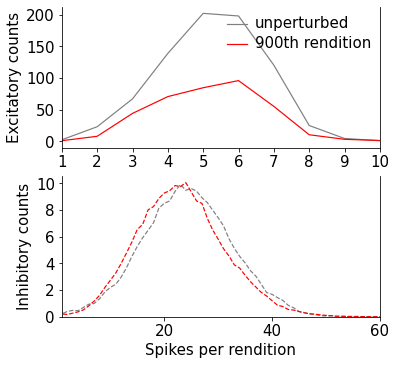

In [205]:
make_figure_3b(single_fr)

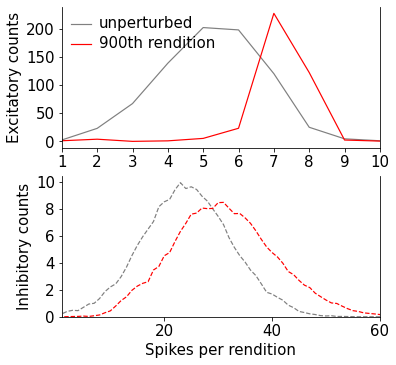

In [206]:
make_figure_3b(pop_fr_1)